In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
"""

In [156]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
#name   ="M1_hazirVeri_toplu_2008-2022_dongulu"
path = "/content/drive/MyDrive/EURUSD_Weekly_23yil_DataFrame"
#df = pd.read_csv(path+".csv")
#df = pd.DataFrame(df,columns=['Date','Open',"High","Low","Close"])

import dill
#dill.dump_session(path+'.db')
dill.load_session(path+'.db')
print("Number of rows and columns:", df.shape)
df.tail(10)

Number of rows and columns: (1209, 5)


,Date,Open,High,Low,Close
1199,2022-01-02,1.13693,1.13778,1.12723,1.13590
1200,2022-01-09,1.13550,1.14829,1.12853,1.14151
1201,2022-01-16,1.14117,1.14342,1.13010,1.13421
1202,2022-01-23,1.13371,1.13447,1.11214,1.11469
1203,2022-01-30,1.11406,1.14836,1.11378,1.14514
1204,2022-02-06,1.14573,1.14950,1.13297,1.13477
1205,2022-02-13,1.13376,1.13955,1.12800,1.13227
1206,2022-02-20,1.13145,1.13907,1.11063,1.12716
1207,2022-02-27,1.11295,1.12464,1.08852,1.09305
1208,2022-03-06,1.09255,1.11213,1.08060,1.09857


In [157]:
train_size = ((len(df)*90)//100)
training_set = df.iloc[:train_size, 1:5].values
test_set = df.iloc[train_size:, 1:5].values

training_set,'Done'

(array([[1.1575 , 1.179  , 1.1447 , 1.1563 ],
        [1.1565 , 1.1642 , 1.1539 , 1.1587 ],
        [1.1579 , 1.1608 , 1.1342 , 1.1367 ],
        ...,
        [1.10788, 1.11756, 1.10735, 1.11648],
        [1.11687, 1.11753, 1.10166, 1.10189],
        [1.10185, 1.10567, 1.0989 , 1.10515]]), 'Done')

In [158]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = training_set#sc.fit_transform(training_set)

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 1:4])
    return np.array(dataX), np.array(dataY)

# Create the data to train our model on:
time_steps_train = 2
X_train, y_train = create_dataset(training_set_scaled, time_steps_train)
print(y_train)
# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train) # 1222, 36, 1
#(740, 60, 1)
'Done'

[[1.1608  1.1342  1.1367 ]
 [1.1397  1.1247  1.126  ]
 [1.136   1.1214  1.1306 ]
 ...
 [1.11756 1.10735 1.11648]
 [1.11753 1.10166 1.10189]
 [1.10567 1.0989  1.10515]]
[[[1.1575 ]
  [1.1565 ]]

 [[1.1565 ]
  [1.1579 ]]

 [[1.1579 ]
  [1.1383 ]]

 ...

 [[1.10314]
  [1.11604]]

 [[1.11604]
  [1.10788]]

 [[1.10788]
  [1.11687]]]


'Done'

In [159]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:train_size, 1:2]
dataset_test = df.iloc[train_size:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps_train:].values
inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps_train, len(df)-train_size+time_steps_train): #519
    X_test.append(inputs[i-time_steps_train:i, 0])
X_test = np.array(X_test)
X_test.shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
#(459, 60, 1)

(121, 2, 1)


In [160]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 250))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 3))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
'Done'

'Done'

In [161]:
model.fit(X_train, y_train, epochs = 100, batch_size = 4096 )

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 1.4760
Epoch 2/100
1/1 [==============================] - 0s 147ms/step - loss: 1.4543
Epoch 3/100
1/1 [==============================] - 0s 140ms/step - loss: 1.4292
Epoch 4/100
1/1 [==============================] - 0s 141ms/step - loss: 1.3967
Epoch 5/100
1/1 [==============================] - 0s 143ms/step - loss: 1.3533
Epoch 6/100
1/1 [==============================] - 0s 138ms/step - loss: 1.2950
Epoch 7/100
1/1 [==============================] - 0s 139ms/step - loss: 1.2174
Epoch 8/100
1/1 [==============================] - 0s 140ms/step - loss: 1.1155
Epoch 9/100
1/1 [==============================] - 0s 148ms/step - loss: 0.9805
Epoch 10/100
1/1 [==============================] - 0s 138ms/step - loss: 0.8116
Epoch 11/100
1/1 [==============================] - 0s 137ms/step - loss: 0.6052
Epoch 12/100
1/1 [==============================] - 0s 140ms/step - loss: 0.3705
Epoch 13/100
1/1 [====================

In [162]:
predicted_stock_price = model.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)
'Done'

'Done'

In [163]:
dataset_test.shape,predicted_stock_price.shape

((121, 1), (121, 3))

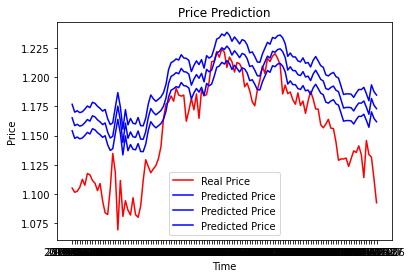

'Done'

In [164]:
# Visualising the results
plt.plot(df.loc[train_size:, "Date"],dataset_test.values,   color = "red",  label = "Real Price")
plt.plot(df.loc[train_size:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Price")
#plt.xticks(np.arange(0,len(df),50))
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
'Done'